***First Part***

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write

Fs = 44100  # Sampling rate in Hz
silence_duration = 0.025  # Silence duration in seconds
file_name = 'generated_noteHarryPotter'

notes = [
    ('B', 4, 0.3), ('E', 5, 0.6), ('G', 5, 0.2), ('F#', 5, 0.3), ('E', 5, 0.6), ('B', 5, 0.4),
    ('A', 5, 0.8), ('F#', 5, 0.8), ('E', 5, 0.6), ('G', 5, 0.2), ('F#', 5, 0.3), ('D#', 5, 0.7),
    ('F', 5, 0.4),('B', 4, 1.6), ('B', 4, 0.3), ('E', 5, 0.6), ('G' ,5 ,0.2),('F#', 5, 0.3),
    ('E', 5, 0.6), ('B', 5, 0.4), ('D', 6, 0.6), ('C#', 6, 0.3), ('C', 6, 0.6), ('G#', 5, 0.3),
    ('C', 5, 0.5), ('B', 5, 0.2), ('A#', 5, 0.3), ('A#', 4, 0.6), ('G', 5, 0.3), ('E', 5, 1.6),
    ('G', 5, 0.3), ('B', 5, 0.6), ('G', 5, 0.3), ('B', 5, 0.6), ('G', 5, 0.3), ('C', 6, 0.6),
    ('B', 5, 0.3), ('A#', 5, 0.6), ('F#', 5, 0.3), ('G', 5, 0.5), ('B', 5, 0.2), ('A#', 5, 0.3),
    ('A#', 4, 0.6), ('B', 4, 0.4), ('B', 5, 1.6), ('G', 5, 0.3), ('B', 5, 0.7), ('G', 5, 0.3),
    ('B', 5, 0.7), ('G', 5, 0.3), ('D', 6, 0.7), ('C#', 6, 0.3), ('C', 6, 0.8), ('G#', 5, 0.3),
     ('C', 6, 0.6), ('B', 5, 0.2), ('A#', 5, 0.3), ('A#', 4, 0.6), ('G', 5, 0.4), ('E', 5, 1), ('E', 5, 1.6)
]

note_frequencies = {
    'C': 261.626, 'B#' : 261.626,'C#': 277.183,'Db': 277.183, 'D': 293.665, 'D#': 311.127,
    'Eb': 311.13, 'E': 329.628, 'Fb': 329.628,'F': 349.228, 'E#': 349.23,'F#': 369.994,
    'Gb': 369.99, 'G': 391.995, 'G#': 415.305, 'Ab': 415.305,'A': 440.00,
    'A#': 466.164, 'Bb': 466.164, 'B': 493.883, 'Cb': 493.883
}

def calculate_frequency(note, octave):
    base_frequency = note_frequencies[note]
    return base_frequency * (2 ** (octave - 4))

def generate_sine_wave(frequency, duration, sampling_rate):
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    return np.sin(2 * np.pi * frequency * t)

signal = np.array([])
for note_data in notes:
    note, octave, duration = note_data
    frequency = calculate_frequency(note, octave)
    sine_wave = generate_sine_wave(frequency, duration, Fs)
    signal = np.concatenate((signal, sine_wave))
    silence = np.zeros(int(Fs * silence_duration))
    signal = np.concatenate((signal, silence))

signal = signal / np.max(np.abs(signal))

signal = (signal * 32767).astype(np.int16)

# Save the generated signal to a .wav file
write( file_name + '.wav', Fs, signal)


***Second Part***

loading the recorded files & calculatin 6 coefficients

<ipython-input-3-7894e8ba100b>:17: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sampling_rate, data = read(file_path)


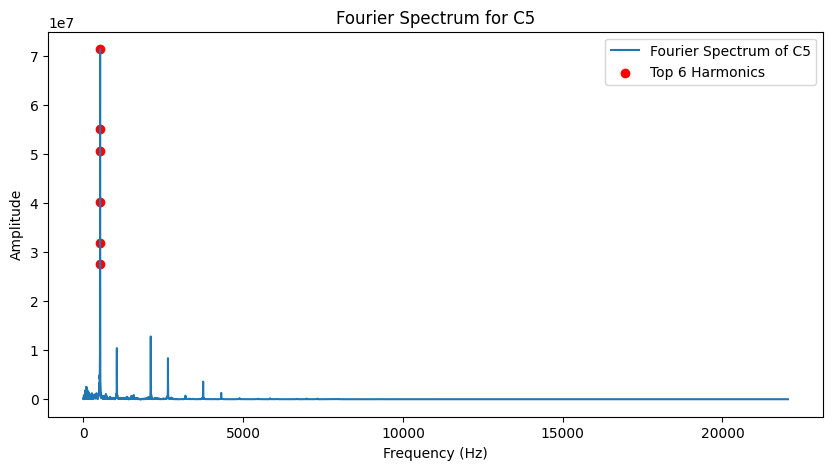

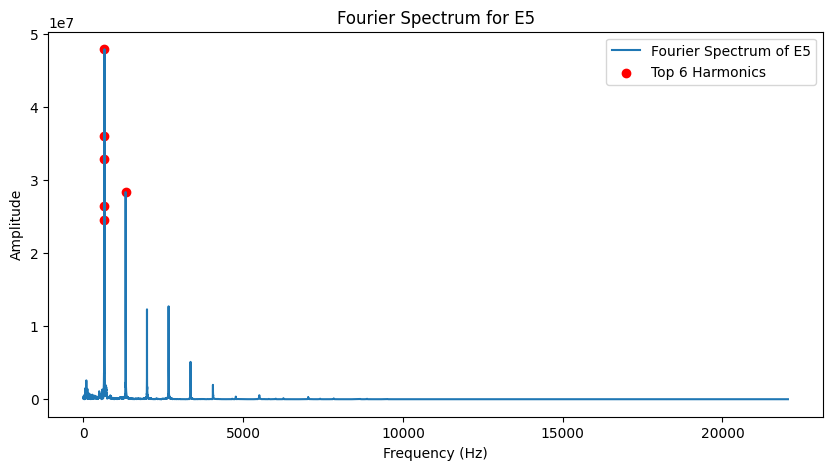

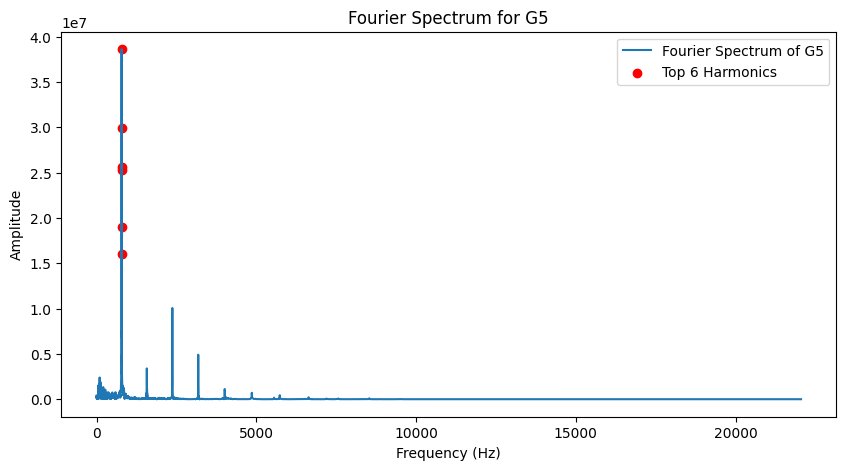

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read
from scipy.fft import fft, fftfreq
import pandas as pd

folder_path = 'recorded_notes'
output_excel = 'harmonics_coefficients.xlsx'

octave_5_notes = ['C5', 'C#5', 'D5', 'D#5', 'E5', 'F5', 'F#5', 'G5', 'G#5', 'A5', 'A#5', 'B5']
harmonics_data = []

for note in octave_5_notes:
    file_path = os.path.join(folder_path, f'{note}.wav')

    sampling_rate, data = read(file_path)
    if data.ndim > 1:
        data = data[:, 0]

    N = len(data)
    fft_values = fft(data)
    fft_amplitudes = np.abs(fft_values)[:N // 2]
    frequencies = fftfreq(N, 1 / sampling_rate)[:N // 2]

    top_indices = np.argsort(fft_amplitudes)[-6:][::-1]
    top_harmonics = [(frequencies[i], fft_amplitudes[i]) for i in top_indices]
    harmonics_data.append({'Note': note, 'Harmonics': top_harmonics})

    if note in ['C5', 'E5', 'G5']:
        plt.figure(figsize=(10, 5))
        plt.plot(frequencies, fft_amplitudes, label=f'Fourier Spectrum of {note}')
        plt.scatter(
            [frequencies[i] for i in top_indices],
            [fft_amplitudes[i] for i in top_indices],
            color='red', label='Top 6 Harmonics'
        )
        plt.title(f'Fourier Spectrum for {note}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

# Save harmonics to Excel
excel_data = []
for entry in harmonics_data:
    row = {'Note': entry['Note']}
    for i, (freq, amp) in enumerate(entry['Harmonics']):
        row[f'H {i + 1} F(Hz)'] = freq
        row[f'H {i + 1} Amp'] = amp
    excel_data.append(row)

df = pd.DataFrame(excel_data)
df.to_excel(output_excel, index=False)


In [4]:
import numpy as np
from scipy.io.wavfile import write

damping_factor = 5  # Adjust to control the decay rate
file_name_optimized = 'noteOptimized'

def generate_note_with_harmonics(note, duration, sampling_rate, damping_factor, harmonics):
    t = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)
    note_signal = np.zeros_like(t)

    for freq, amp in harmonics:
        envelope = np.exp(-damping_factor * t)  # Apply damping
        harmonic_wave = amp * np.sin(2 * np.pi * freq * t) * envelope
        note_signal += harmonic_wave  # Add each harmonic to the signal

    return note_signal

harmonics_dict = {entry['Note']: entry['Harmonics'] for entry in harmonics_data}  # Create lookup


optimized_signal = np.array([])
for note_data in notes:
    note, octave, duration = note_data
    note_key = f'{note}{octave}'

    if note_key in harmonics_dict:
        harmonics = harmonics_dict[note_key]
    else:
        harmonics = [(calculate_frequency(note, octave), 1)]


    note_signal = generate_note_with_harmonics(note, duration, Fs, damping_factor, harmonics)

    optimized_signal = np.concatenate((optimized_signal, note_signal))
    silence = np.zeros(int(Fs * silence_duration))
    optimized_signal = np.concatenate((optimized_signal, silence))


optimized_signal = optimized_signal / np.max(np.abs(optimized_signal))
optimized_signal = (optimized_signal * 32767).astype(np.int16)


write(file_name_optimized + '.wav', Fs, optimized_signal)

***Bonous Part***

In [75]:
import numpy as np
from scipy.io.wavfile import read
from scipy.signal import find_peaks
from scipy.fft import fft

def identify_note_frequency(frequency, note_frequencies):
    min_diff = float('inf')
    identified_note = None
    for note, base_frequency in note_frequencies.items():
        for octave in range(0, 8):
            note_frequency = calculate_frequency(note, octave)
            diff = abs(frequency - note_frequency)
            if diff < min_diff:
                min_diff = diff
                identified_note = (note, octave)
    return identified_note

file_name = 'generated_noteHarryPotter.wav'
Fs, signal = read(file_name)

signal = signal / np.max(np.abs(signal))

peaks, _ = find_peaks(signal, height=0.02, distance=Fs//10)

extracted_notes = []
for peak in peaks:
    window_size = Fs // 100
    start = max(0, peak - window_size // 2)
    end = min(len(signal), peak + window_size // 2)

    segment = signal[start:end]
    spectrum = np.abs(fft(segment))[:len(segment) // 2]
    frequencies = np.fft.fftfreq(len(segment), 1 / Fs)[:len(segment) // 2]
    dominant_frequency = frequencies[np.argmax(spectrum)]

    identified_note = identify_note_frequency(dominant_frequency, note_frequencies)
    extracted_notes.append(identified_note)

def remove_consecutive_duplicates(input_list):
    if not input_list:
        return []

    result = [input_list[0]]

    for i in range(1, len(input_list)):
        if input_list[i] != input_list[i - 1]:
            result.append(input_list[i])

    return result

final_notes = remove_consecutive_duplicates(extracted_notes)
print(final_notes)

[('B', 4), ('E#', 5), ('G', 5), ('E#', 5), ('B', 5), ('A', 5), ('E#', 5), ('G', 5), ('E#', 5), ('D', 5), ('E#', 5), ('B', 4), ('E#', 5), ('G', 5), ('E#', 5), ('B', 5), ('D', 6), ('C#', 6), ('B', 5), ('G', 5), ('B', 4), ('B', 5), ('A', 5), ('B', 4), ('G', 5), ('E#', 5), ('G', 5), ('B', 5), ('G', 5), ('B', 5), ('G', 5), ('B', 5), ('A', 5), ('E#', 5), ('G', 5), ('B', 5), ('A', 5), ('B', 4), ('B', 5), ('G', 5), ('B', 5), ('G', 5), ('B', 5), ('G', 5), ('D', 6), ('C#', 6), ('B', 5), ('G', 5), ('B', 5), ('A', 5), ('B', 4), ('G', 5), ('E#', 5)]
